In [3]:
import pandas as pd
import numpy as np
import spacy
import re
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from explore_data import *
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from bs4 import BeautifulSoup


import spacy

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [85]:
df= pd.read_csv('final_data/api_data.csv',index_col=0)
print(df.shape)
df.head()

(4417, 6)


,title,score,id,subreddit,num_comments,body
0,Do we know of any diseases dinosaurs could have been infected with?,2,hcxfcd,askscience,0,"I get that paleontology doesn't get much in the way of soft tissue or the ability to look at micro organisms, but I thought I'd ask.\n\nMaybe some of the same diseases that birds get today?"
1,Do all animals have an internal compass? How does it work? How come humans don't have this ability?,4,hcqbk1,askscience,3,Always wondered how birds and fish never got lost whike migrating. Anyone know why?
2,Does a plane have to slow down after dropping a payload?,1,hcplk2,askscience,4,"If a plane drops a heavy payload while in flight (nuclear bomb? idk), wouldn't a sudden imbalance in the forces propel the plane up suddenly? Then does the plane have to decelerate suddenly?"
3,What causes the rotational speeds of planets to differ so greatly?,3,hcpqvw,askscience,7,I noticed that the rotational speeds of planets vary greatly as they get further from the Sun. Venus takes 243 days to complete one rotation while Jupiter only takes 9 hours. \n\nWhat are the factors that influence rotational speed of planets and why does it differ so much between the inner planets and the outer planets?
4,"We have active cancer cells in labs that have been grown since the 50s and don't experience senescence, would it be possible to utilise this 'immortality' to grow organs?",3,hcpzjo,askscience,12,NaN


In [86]:
#Shuffling the data
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,title,score,id,subreddit,num_comments,body
0,Having Too Much Information Can Lead Us To Make Worse Decisions,5,fvxcdc,psychology,0,NaN
1,"Because of Rising CO2, Trees Might Be Warming the Arctic",1,gpuxcf,EverythingScience,0,NaN
2,Best Clustering/Grouping method to solve this problem?,2,fsxgeq,datascience,9,"I want to cluster or group my data into 3 categories:-\n- High performing companies\n- Medium Performing companies\n- Low Performing companies\n\nI have a dataset which has the company name, company rating, company turnover, Total Business transacted. \n\nI could probably loop through them and based on a couple conditions I could classify them in these categories but there are so many companies and so many different permutations and combinations that can be made. So I am not sure if that's the best and most efficient way.\n\nWill K-means clustering be a good and viable technique to use here?"
3,Schema therapy for eating disorders : therapist reflections,2,g740pj,psychology,0,NaN
4,[ELI5] Why developers who projects websites still have job when there is a lot of w (mostly free) sites witch gives you templates for creating one by yourself?,0,hcwjmj,explainlikeimfive,2,NaN


### Explore data

In [87]:
#how many unique titles do we have?
df['title'].nunique() 

4355

There are 62 duplicate titles in this dataset

In [88]:
#how many unique subreddits do we have?
df['subreddit'].nunique() 

5

In [89]:
df[['title', 'subreddit']].duplicated().sum()

52

In [9]:
#dropping those uplicate
df.drop_duplicates(subset=['title', 'subreddit'], keep='last', inplace=True)

# distribution of target
df['subreddit'].value_counts()

explainlikeimfive    991
EverythingScience    961
psychology           862
datascience          821
askscience           730
Name: subreddit, dtype: int64

In [10]:
# Check for nulls
df.isnull().sum()

title              0
score              0
id                 0
subreddit          0
num_comments       0
body            2646
dtype: int64

In [11]:
# Examine rows with null texts
df[df.body.isnull()]

,title,score,id,subreddit,num_comments,body
0,UAE's first Mars mission 'to launch within weeks',3,gzkixo,EverythingScience,0,NaN
1,Lunar Eclipse to be visible in these parts of ...,3,gwo86v,EverythingScience,2,NaN
3,"Because of Rising CO2, Trees Might Be Warming ...",1,gpuxcf,EverythingScience,0,NaN
4,7 Things Russia's New Super Rocket and NASA's ...,2,h7y163,EverythingScience,0,NaN
5,The World’s Biggest Study on Loneliness,1,h07zm4,EverythingScience,0,NaN
...,...,...,...,...,...,...
4408,ELI5: How did the English language become as g...,5,hbj86x,explainlikeimfive,9,NaN
4411,Experiment shows human speech generates drople...,49,gjr2tl,EverythingScience,1,NaN
4412,Effects of internet CBT for health anxiety on ...,5,gj1raj,psychology,2,NaN
4413,MicroCT takes an amazing deep look inside the ...,1,ha79ny,EverythingScience,0,NaN


In [12]:
# Replace null texts with empty string
df.body.fillna(value='', inplace=True)

In [13]:
# Put titles and texts into a single column.
df['text'] = df['title'] + ' ' + df['body']

In [14]:
df = df[['text', 'score', 'id', 'subreddit','num_comments']]
print(df.shape)
df.head()

(4365, 5)


,text,score,id,subreddit,num_comments
0,UAE's first Mars mission 'to launch within wee...,3,gzkixo,EverythingScience,0
1,Lunar Eclipse to be visible in these parts of ...,3,gwo86v,EverythingScience,2
2,eli5: Boron in pea protein powders? Since peas...,1,hbplru,explainlikeimfive,1
3,"Because of Rising CO2, Trees Might Be Warming ...",1,gpuxcf,EverythingScience,0
4,7 Things Russia's New Super Rocket and NASA's ...,2,h7y163,EverythingScience,0


In [15]:
#read few samples from data science subreddit
pd.set_option('display.max_colwidth', 0)
df[df['subreddit']=='datascience']['text'].sample(3)

2514    How important is title? Would you consider it a "step down" to go from Data Scientist to Senior Analyst/Product Analyst?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [16]:
#read few samples from data science subreddit
pd.set_option('display.max_colwidth', 0)
df[df['subreddit']=='psychology']['text'].sample(3)

429     Does this article from 1971 and the studies cited about homosexuality sound antiquated/outdated from the point of view of 2020 Psychology? Or is it largely correct? Does it read politically incorrect from today's point of view? 
2561    How to help young children regulate their emotions and behaviors during the pandemic                                                                                                                                                
1194    Exploring the link between education and climate change                                                                                                                                                                             
Name: text, dtype: object

In [17]:
# No.of sample in the dataset
print(f'No. of  Samples: {df.shape[0]}')

No. of  Samples: 4365


In [18]:
median_words_per_sample = get_num_words_per_sample(df['text'].values)
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 23.0


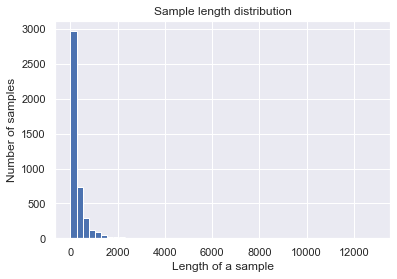

In [19]:
plot_sample_length_distribution(df['text'].values)

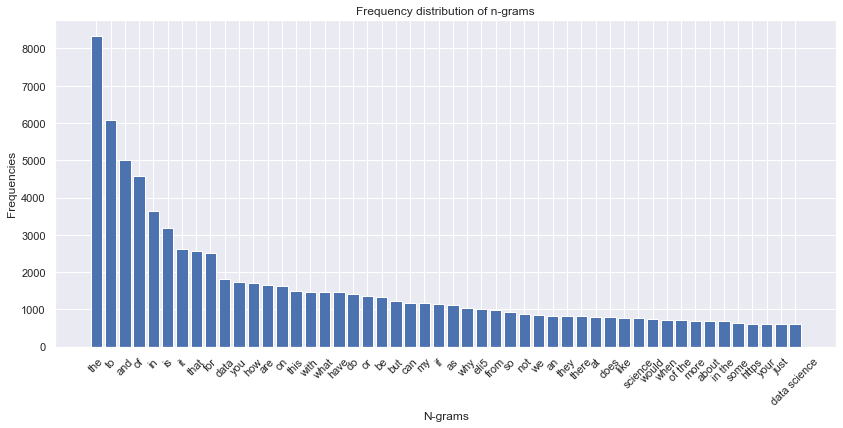

In [20]:
#Distribution showing the frequency (number of occurrences) of each word in the dataset.

plot_frequency_distribution_of_ngrams(df['text'].values,
                                      ngram_range=(1, 2),
                                      num_ngrams=50)

In [21]:
sw_ratio = df.shape[0] / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 189


### Explore Text

In [22]:
df['text'].value_counts().to_frame()

,text
"Has Twitter just had its saddest fortnight ever? - ""A tool that quantifies global happiness on social media recorded an unprecedented dip in mood starting in May.""",2
"Women perform better on math and verbal tests at higher temperatures while men perform better at lower temperatures, according to a laboratory study on German students. The research also found that the gain in cognitive performance for women is higher than the loss in men’s as the temperature rises.",2
Young people with early psychosis may not require antipsychotic medications to recover,2
Awessssommmeee! Stretchable Words Make Language More Emotive - The latest research (2020) on stretched words by Tyler Gray and colleagues at the University of Vermont is the most comprehensive study to date that uses big data to analyze how people use stretched words on a social media platform.,2
"""Shouting"" and spelling mistakes add together to make online health information appear doubly less trustworthy",2
...,...
Life itself is a datascience! Constantly predicting the next move,1
This Is How You Live When the World Falls Apart: The Great Alaska Earthquake of 1964 surprised everyone by showing that natural disasters can bring out more kindness than selfishness.,1
Wildlife territorial behavior could play larger role in disease spread than thought,1
"To find brain connectivity differnces in groups, most of people uses the Network based statistics of Zalesky, we published and method which instead of t-test is using sparsity. 1. Feedback is wolcome. 2. Do you think we have solved the issue of finding differences in connectivity?",1


In [23]:
import re
import nltk
import pandas as pd
from nltk.stem import PorterStemmer
 
def my_preprocessor(text):
    
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+","",text) # normalize certain words
    # remove special characters and digits
    text=re.sub("(\\d|\\W|\\n)+"," ",text)
    
    return text

In [24]:
df['clean_text'] = df['text'].apply(my_preprocessor)
df[['text', 'clean_text']].sample(5)

,text,clean_text
2713,ELI5: how can laughing bring us to tears?,eli how can laughing bring us to tears
4323,"Exotic, fifth state of matter created on the space station",exotic fifth state of matter createdthe space station
1764,"We think that we will choose our personal and professional advisors based on reasoned criteria about their expertise, competence and experience. In practice, we go more with our gut than our head, choosing the person who shows enthusiasm for us and our goals.",we think that we will choose our personalprofessional advisors basedreasoned criteria about their expertise competenceexperiencepractice we go more with our gut than our head choosingperson who shows enthusiasmusour goals
3063,ELI5 how do they do those one way windows? Where you can see only from one side.,eli how do they do those one way windows where you can see only from one side
4164,Why does peritoneal dialysis have to be done much more often (4 times a day) compared to haemodialysis (a few times a week)?,why does peritoneal dialysis have to be done much more often times a day compared to haemodialysis a few times a week


In [25]:
# transform target variable
encoder = LabelEncoder()
encoder.fit(df['subreddit'])
y = encoder.transform(df['subreddit'])
list(encoder.classes_)

['EverythingScience',
 'askscience',
 'datascience',
 'explainlikeimfive',
 'psychology']

### Build a Baseline TF-IDF Model

In [26]:
# Train/Test split before creating features
X_train, X_test, y_train, y_test= train_test_split(df['clean_text'], y,test_size = 0.2, random_state= 42, stratify= df['subreddit'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3492,), (873,), (3492,), (873,))

In [32]:
#create pipline
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2),
                       min_df=2, 
                       max_df=0.75,
                       max_features=20000)
RF_model = RandomForestClassifier()

In [28]:
# Get sparse dtm
dtm = vect.fit_transform(X_train)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(dtm.shape)
dtm.head()

(3492, 9526)


,_and,_and _share,_bleep,_bleep bloop_,_content,_data,_data _reports,_do,_do _you,_link,_link sk,_matrix,_reports,_reports https,_share,_share _your,_track,_track _and,_you,_you _track,_your,_your _data,aa,ab,abilities,ability,ability dependthe,abit,able,able communicate,able figure,able learn,able look,able make,able play,able produce,able provide,able pull,able tell,able use,abnormally,abolish,aboriginal,aboutcompany,aboutdata,aboutdata science,aboutkinds,aboutsun,aboutwhole,abs,abs pii,absence,absolute,absolutely,absolutely appropriategeneral,absolutely idea,absorbed,abstract,abuse,ac,academia,academic,academics,academy,accelerate,accelerated,accelerating,acceleration,accept,acceptable,acceptance,accepted,accepting,access,access public,accessible,accident,according,according laboratory,according new,according recent,according research,according study,account,accounta,accounts,accumulate,accuracy,accurate,accurately,acetaminophen,achieve,achieve maybe,achieved,achievement,achievements,acid,acidic,acids,acrossboard,...,worried apathetic,worry,worrying,worse,worst,worth,worth don,worth learn,worth submitting,wouldn,wouldn make,wouldn mean,wounds,wow,wp,wp content,wrap,wrap head,wrapping,wrapping head,write,write production,write sql,writing,writing code,writing sql,written,wrong,wrong just,wrong missing,wrongadopt,wrongadopt human,wrongthat,wrote,ww,www,www careerfair,www cdc,www coursera,www gonudgeyourself,www google,www kaggle,www nature,www ncbi,www reddit,www sciencedirect,www theguardian,www udemy,xgboost,xy,yawn,year,year ago,year better,year just,year old,year studylongest,yeara,years,years ago,years away,years data,years experience,years know,years old,years send,years work,years years,yearsthe,yeast,yellow,yes,yesterday,yield,yields,yo,york,york city,youa,youadvance,youit,youknow,young,young children,younger,youtu,youtube,youtube channel,youyour,youyour helpadvance,youyour time,yr,yr old,zealand,zero,zombie,zone,zoom,zoomed,zoster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0

Text(0, 0.5, 'Word')

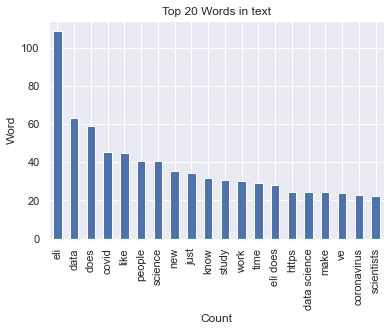

In [29]:
#sum_words = dtm.sum(axis=0) 
wc_top20= dtm.sum(axis=0).sort_values(ascending=False)[:20]
wc_top20.plot(kind='bar')
plt.title('Top 20 Words in text')
plt.xlabel('Count')
plt.ylabel('Word')

In [33]:
# Define the Pipeline
RFC_model = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', RF_model)         # RandomForest Classifier
])

In [34]:
parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 10000, 20000),
    'clf__n_estimators': (100, 500),
    'clf__max_depth': (10, 20, None)
}

grid_search = GridSearchCV(RFC_model, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
y_pred = RFC_model.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.75,
                                                        max_features=20000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (10, 20, None),
                         'clf__n_estimators': (100, 500),
                         'vect__max_df': (0.7, 1.0),
                         'vect__max_features': (5000, 10000, 20000),
                         'vect__min_df': (2, 5, 10)},
             verbose=1)

In [35]:
print("Best params: {}".format(grid_search.best_params_))
print('Train score: {}, Test score {}'.format(round(grid_search.best_score_, 4), round(grid_search.best_estimator_.score(X_test, y_test), 4)))

Best params: {'clf__max_depth': None, 'clf__n_estimators': 500, 'vect__max_df': 0.7, 'vect__max_features': 5000, 'vect__min_df': 2}
Train score: 0.7987, Test score 0.8144


In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
my_tags = list(encoder.classes_)
print(classification_report(y_test, y_pred,target_names=my_tags))

                   precision    recall  f1-score   support

EverythingScience       0.64      0.83      0.72       192
       askscience       0.81      0.68      0.74       146
      datascience       0.95      0.84      0.89       164
explainlikeimfive       1.00      1.00      1.00       198
       psychology       0.74      0.68      0.71       173

         accuracy                           0.81       873
        macro avg       0.83      0.80      0.81       873
     weighted avg       0.83      0.81      0.82       873



### Naive Bayes Classifier for Multinomial Models

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', MultinomialNB())         # RandomForest Classifier
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.588774341351661
                   precision    recall  f1-score   support

EverythingScience       0.62      0.37      0.46       192
       askscience       0.71      0.49      0.58       146
      datascience       0.78      0.76      0.77       164
explainlikeimfive       0.46      0.96      0.63       198
       psychology       0.66      0.33      0.44       173

         accuracy                           0.59       873
        macro avg       0.65      0.58      0.57       873
     weighted avg       0.64      0.59      0.57       873



### Linear Support Vector Machine

In [55]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect',vect),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7250859106529209
                   precision    recall  f1-score   support

EverythingScience       0.52      0.78      0.62       192
       askscience       0.72      0.60      0.65       146
      datascience       0.81      0.83      0.82       164
explainlikeimfive       1.00      1.00      1.00       198
       psychology       0.63      0.35      0.45       173

         accuracy                           0.73       873
        macro avg       0.74      0.71      0.71       873
     weighted avg       0.74      0.73      0.72       873



### MLP Model

In [70]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [71]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    mlp_model = models.Sequential()
    mlp_model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        mlp_model.add(Dense(units=units, activation='relu'))
        mlp_model.add(Dropout(rate=dropout_rate))

    mlp_model.add(Dense(units=op_units, activation=op_activation))
    return mlp_model

In [72]:
vect.fit(X_train)
X_train_tfidf = vect.transform(X_train)
X_test_tfidf = vect.transform(X_test)

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

#creating the model
mlp_model = mlp_model(2, 5, 0.02, X_train_tfidf.shape[1:],5)

# Compile Model
mlp_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 380       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
Total params: 410
Trainable params: 410
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Train and validate model
history = mlp_model.fit(X_train_tfidf.toarray(), y_train, epochs=50, 
                         validation_data=(X_test_tfidf.toarray(),y_test),
                         batch_size= 128,
                         callbacks=[tf.keras.callbacks.EarlyStopping(
                         monitor='val_loss',
                         verbose=2,
                            patience=2)])

Train on 3492 samples, validate on 873 samples
Epoch 1/50
3492/3492 [==============================] - 1s 306us/sample - loss: 1.6076 - accuracy: 0.2219 - val_loss: 1.5980 - val_accuracy: 0.2990
Epoch 2/50
3492/3492 [==============================] - 0s 22us/sample - loss: 1.5953 - accuracy: 0.2806 - val_loss: 1.5857 - val_accuracy: 0.3127
Epoch 3/50
3492/3492 [==============================] - 0s 20us/sample - loss: 1.5822 - accuracy: 0.3007 - val_loss: 1.5718 - val_accuracy: 0.3345
Epoch 4/50
3492/3492 [==============================] - 0s 23us/sample - loss: 1.5673 - accuracy: 0.3508 - val_loss: 1.5531 - val_accuracy: 0.4559
Epoch 5/50
3492/3492 [==============================] - 0s 20us/sample - loss: 1.5463 - accuracy: 0.4419 - val_loss: 1.5287 - val_accuracy: 0.4880
Epoch 6/50
3492/3492 [==============================] - 0s 17us/sample - loss: 1.5188 - accuracy: 0.4714 - val_loss: 1.4974 - val_accuracy: 0.5017
Epoch 7/50
3492/3492 [==============================] - 0s 15us/sample

In [75]:
loss, accuracy = mlp_model.evaluate(X_train_tfidf.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mlp_model.evaluate(X_test_tfidf.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7354
Testing Accuracy:  0.7274


In [76]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    

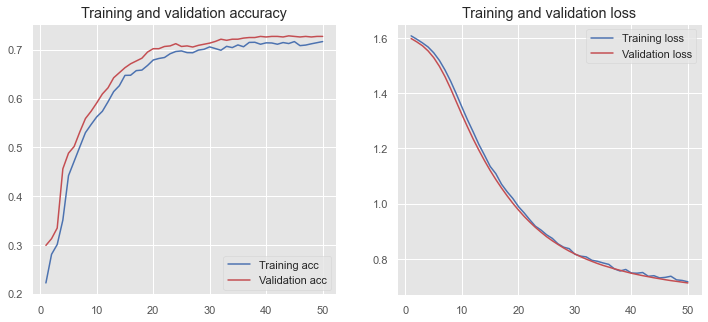

In [77]:
plot_history(history)

### Searching for the the best Architecture of the model using Kerastuner

In [78]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

"""
This model Tunes:
- Number of Hidden Layers in the network
- Number of Neurons in each Hidden Layer
- Learning Rate in Adam

"""

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i), 
                                     min_value=16,
                                     max_value=256,
                                     step=32),
                        activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [79]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Subreddit')

INFO:tensorflow:Reloading Oracle from existing project my_dir\Subreddit\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\Subreddit\tuner0.json


In [80]:
tuner.search(X_train_tfidf.toarray(), y_train,
             epochs=5,
             verbose=False,
             validation_data=(X_test_tfidf.toarray(), y_test))

INFO:tensorflow:Oracle triggered exit


In [81]:
model = tuner.get_best_models()
tuner.results_summary()

In [51]:
list_pickle_path = 'model.pkl'
# Create an variable to pickle and open it in write mode
pickle.dump(grid_search, open(list_pickle_path, 'wb'))

In [320]:
list_pickle_path = 'encoder.pkl'
# Create an variable to pickle and open it in write mode
pickle.dump(encoder, open(list_pickle_path, 'wb'))

In [329]:
encoder = pickle.load(open('encoder.pkl', 'rb'))
model = pickle.load(open('model.pkl', 'rb'))

In [336]:
pred = model.predict(["i want to learn Data science"])
pred_encoded = encoder.inverse_transform(pred)
print ("predicted class:", pred_encoded)

predicted class: ['datascience']
